# Loading the libraries


In [167]:
library(twitteR)
library(ggplot2)
library(sp)
library(maps)
library(maptools)
library(rjson)
library(httr)
library(sqldf)
library(ggmap)

# Twitter Authentication

In [3]:
 setup_twitter_oauth("U4mDPM6y229fufLIPju94JXcR","ilXC4tbfLUvzqzFQiCBusDP6fVJkJcP216XIpp6O0thTBWEtFw","775912133699796992-hxJUUpXwjQISZ3lCCUjqOphCDoNb9qa","klYpv4kNCzQ47UUdzJkIW6OM2h83nT004r7DeQJFl0nMj")

[1] "Using direct authentication"


# Twitter Search for a Hastag via Variable

In [135]:
hashtag="superbowl"
twitterData<-searchTwitter(hashtag,n=5000)
data_frame<-twListToDF(twitterData)
write.csv(data_frame,file="Tweets4.csv",na="")

# Extracting userInfo from the gathered Tweets

In [6]:
userInfo <- lookupUsers(data_frame$screenName)
new_dataFrame<-twListToDF(userInfo)
usersWithLoc <- !is.na(new_dataFrame$location)

# Use Google Geocode API to get the latitude and longitude

In [ ]:
locations <- geocode(new_dataFrame$location[usersWithLoc])
locations<-subset(locations,lon < (-60) & lat > (25) & lat< 50)
locations<-na.omit(locations)


# Use DataScienceToolkit to get the geocode for the locations

In [39]:
location <- toJSON(new_dataFrame$location[usersWithLoc])
json <- fromJSON(content(POST("http://www.datasciencetoolkit.org/street2coordinates",body=location),type="text"))
gdata<-subset(as.data.frame(do.call("rbind", json)),select = c("longitude","latitude"))

#Eliminating international tweets and considering only locations in USA
gdata<-subset(gdata,longitude < (-60) & latitude > (25) & latitude< 50)

#Changing from list type to Numeric
gdata$latitude<-unlist(gdata$latitude)
gdata$longitude<-unlist(gdata$longitude)

#Eliminationg NA values
locations<-na.omit(gdata)
class(locations)

No encoding supplied: defaulting to UTF-8.


[1] "data.frame"

In [37]:
locations

longitude   latitude 
San Francisco, CA          -122.727802 37.784827
Loveland, CO               -105.179966 40.364469
California, USA            -118.021353 35.125624
Portland, OR               -122.690794 45.507856
Thunder Bay, ON, CA        -122.415874 40.320601
Long Beach, CA             -118.168135 33.803448
Los Angeles, CA            -118.248405 33.973951
Victorville, CA            -117.411053 34.448755
Beverly Hills, CA          -118.298662 33.786594
Gilbert, AZ                -111.815281 33.335401
Western Colorado           -104.997203 39.832208
West Hollywood, CA 90069   -118.381697 34.093828
El Centro, CA              -115.598602 32.770275
Seattle, Wa                -121.803388 47.432251
Garden of Evil, Ca         -120.857125 38.851299
Helena, MT                 -112.21037  46.527398
Las Vegas, NV              -115.206969 36.301068
Lakeside, CA               -116.898945 32.893498
Silverthorne, CO           -106.000063 39.670756
California                 -118.021353 35.125624
San Mateo, CA              -122.32253  37.573485
Kent, WA                   -122.195772 47.405479
Ventura, California        -119.358352 34.330829
Calabasas, CA              -118.671028 34.12331 
Marina del Rey, CA         -118.457852 33.979007
Seattle, WA                -121.803388 47.432251
Coalinga, CA               -120.381432 36.247025
Chino Hills, CA            -117.75888  33.9938  
Not here, USA              -123.453204 44.061101
Denver, CO                 -105.069027 39.743291
...                        ...         ...      
Cedar Hill, TX             -101.20432  34.143407
Mountain View, CA          -121.705327 37.189396
Donald Trump's America     -120.41983  46.448062
Huntington Beach, CA       -117.999227 33.660297
Goodyear, AZ               -112.461482 33.46194 
West Sacramento, CA        -121.537801 38.591854
Albuquerque, NM            -106.651137 35.084491
Layton, UT                 -111.92614  41.088889
Rancho Cordova, CA         -121.280328 38.604269
Sacramento, CA             -121.555406 38.380456
Los Altos, California, USA -122.144416 37.357472
Providence, Las Vegas, NV  -115.200886 36.169651
San Jose, CA               -121.705327 37.189396
Federal Way, Washington    -122.315773 47.307713
inglewood, California      -118.358654 33.956526
Los Angeles, California    -117.885359 35.187133
southern california        -117.692883 35.590326
Hollywood, CA              -118.326743 34.098343
San Dimas, CA              -117.80673  34.10668 
Colorado Springs, CO       -104.857828 38.861469
Seattle Wa                 -121.803388 47.432251
las vegas, nevada          -115.206969 36.301068
Longmont, CO               -105.103179 40.164837
Olympia, WA                -122.869079 46.984767
Tucson, AZ.                -110.970869 32.217975
Denver, Colorado           -105.069027 39.743291
Antelope, CA               -121.366613 38.716091
southern california        -117.692883 35.590326
Nueva York, USA            -117.148783 33.801262
Atwater, CA                -120.647347 37.317255

# Making Clusters of tweets based on State Data and maintaining a new DataFrame

In [101]:
# Prepare SpatialPolygons object with one SpatialPolygon

    states <- map('state', fill=TRUE, col="transparent", plot=FALSE)
    IDs <- sapply(strsplit(states$names, ":"), function(x) x[1])
    spatialStates <- map2SpatialPolygons(states, IDs=IDs,
                     proj4string=CRS(""))

    # Convert locations DF to a SpatialPoints object 
    SpatialPointsObj <- SpatialPoints(locations, 
           proj4string=CRS(""))

    # Use 'over' to get _indices_ of the Polygons object containing each point 
    indices <- over(SpatialPointsObj, spatialStates)

    # Return the state names of the Polygons object containing each point
    stateNames <- sapply(spatialStates@polygons, function(x) x@ID)
    states<-stateNames[indices]
   

        df<-as.data.frame(states)
 #Eliminationg NA values       
        df<-na.omit(df)
        #write.csv(df,file="final2.csv")
        #
        

In [136]:
#write.csv(df,file="final2.csv")
#file<-read.csv(file.choose())
#file$X<-NULL
#master<-rbind(df,file)

# Calculating Count and grouping the Tweets by State

In [138]:
#SQL statement to calculate frequency and grouping thr tweets
Blob=sqldf("select states,count(*) as count from master group by states order by count desc")



# Calculating geocode of state 

In [155]:
Blob[1] <- data.frame(lapply(Blob[1], as.character), stringsAsFactors=FALSE)
locations_group <- geocode(Blob$states,output="latlon")

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=california&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=texas&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=florida&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=new%20york&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=kansas&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=georgia&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=massachusetts&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=pennsylvania&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=new%20jersey&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?

In [160]:
locations_group

lon        lat     
1  -119.41793 36.77826
2   -99.90181 31.96860
3   -81.51575 27.66483
4   -74.00594 40.71278
5   -98.48425 39.01190
6   -82.90008 32.16562
7   -71.38244 42.40721
8   -77.19452 41.20332
9   -74.40566 40.05832
10  -86.58045 35.51749
11  -82.90712 40.41729
12  -85.60236 44.31484
13  -89.39853 40.63312
14  -77.03687 38.90719
15  -86.13490 40.26719
16  -88.78787 43.78444
17 -111.09373 34.04893
18  -79.01930 35.75957
19  -78.65689 37.43157
20  -91.96233 30.98430
21 -120.74014 47.75107
22  -76.64127 39.04575
23  -84.27002 37.83933
24 -116.41939 38.80261
25  -91.83183 37.96425
26  -97.09288 35.00775
27 -120.55420 43.80413
28 -105.78207 39.55005
29  -71.47743 41.58009
30  -73.08775 41.60322
31  -94.68590 46.72955
32  -86.90230 32.31823
33  -69.44547 45.25378
34  -81.16372 33.83608
35 -111.09373 39.32098
36  -91.83183 35.20105
37 -105.87009 34.51994
38  -72.57784 44.55880
39  -93.09770 41.87800
40 -110.36257 46.87968
41  -99.90181 41.49254
42  -71.57240 43.19385
43  -89.39853 32.35467
44  -80.45490 38.59763
45 -114.74204 44.06820
46  -75.52767 38.91083
47 -101.00201 47.55149
48 -107.29028 43.07597

In [159]:
Blob#count

states               count
1  california           344  
2  texas                241  
3  florida              143  
4  new york             128  
5  kansas               108  
6  georgia              101  
7  massachusetts         99  
8  pennsylvania          98  
9  new jersey            70  
10 tennessee             69  
11 ohio                  54  
12 michigan              53  
13 illinois              50  
14 district of columbia  46  
15 indiana               41  
16 wisconsin             33  
17 arizona               31  
18 north carolina        31  
19 virginia              31  
20 louisiana             30  
21 washington            28  
22 maryland              27  
23 kentucky              26  
24 nevada                26  
25 missouri              25  
26 oklahoma              25  
27 oregon                24  
28 colorado              20  
29 rhode island          20  
30 connecticut           19  
31 minnesota             19  
32 alabama               16  
33 maine                 15  
34 south carolina        14  
35 utah                  11  
36 arkansas              10  
37 new mexico             9  
38 vermont                9  
39 iowa                   7  
40 montana                7  
41 nebraska               7  
42 new hampshire          7  
43 mississippi            6  
44 west virginia          6  
45 idaho                  4  
46 delaware               3  
47 north dakota           3  
48 wyoming                2

# Plotting Map

In [164]:
usaMap <- map_data("state")
mapPlot<-ggplot(usaMap)+geom_path(aes(x = long, y = lat, group = group))


In [165]:
mapPlot <- mapPlot +geom_point(data = locations_group, aes(x = lon, y = lat,size=Blob$count),
                   colour = "RED")

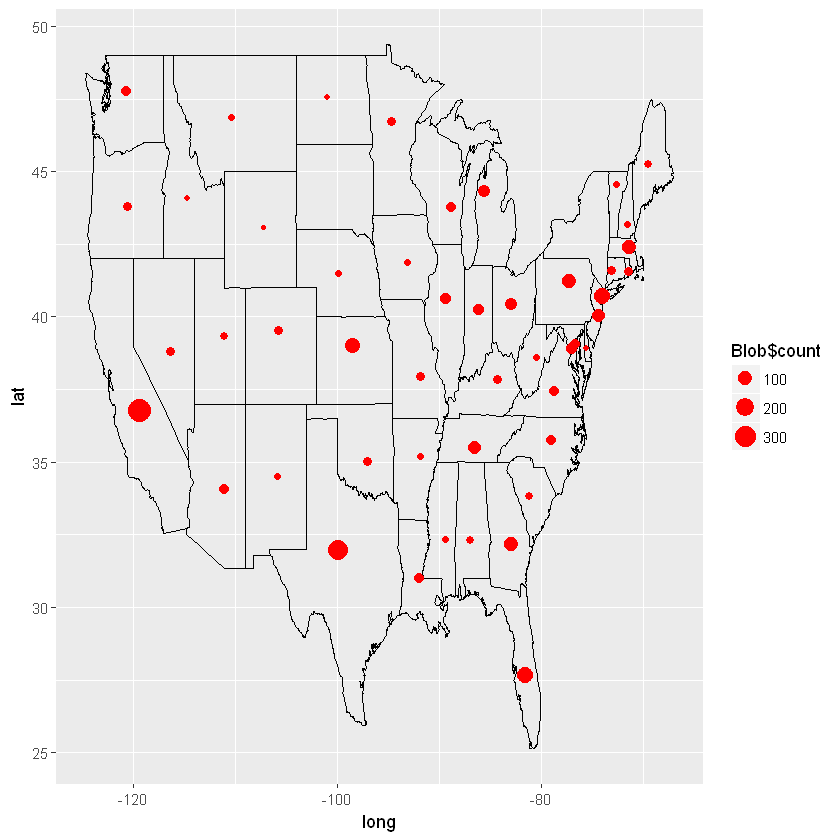

In [168]:
mapPlot